In [69]:
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
from model import LeNet5

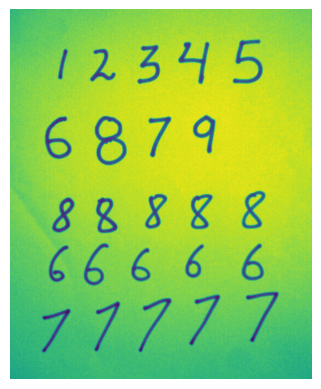

In [93]:
# reading in the 'greyscale' image 
img = cv2.imread("cards/card2.png")
img_disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_disp)
plt.axis("off");

# grayscale conversion
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)
plt.axis('off');

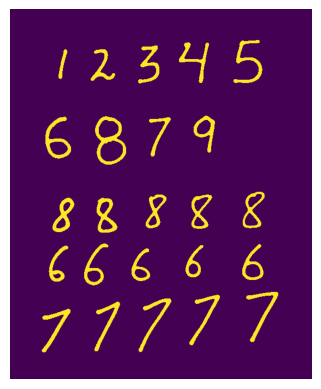

In [94]:
# gaussian blurring
img_gauss_blurred = cv2.GaussianBlur(img_gray, (5, 5), 0) # 0: the gaussian stddev is automatically decided based on the kernel size
plt.imshow(img_gauss_blurred)
plt.axis("off");

# applying binary inverse thresholding
_, img_th = cv2.threshold(img_gauss_blurred, 90, 255, cv2.THRESH_BINARY_INV)
plt.imshow(img_th)
plt.axis('off');

In [95]:
# finding contours 
ctrs, _ = cv2.findContours(img_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# param1: pass as '.copy()' always as countour finding modifies the original image slightly
# RETR_EXTERNAL: focuses on the external boundary only where black ends and white begins (points where there is an initial sudden increase in slope)
# CHAIN_APPROX_SIMPLE: instead of storing every point on the boundary, it saves only the start and the end points of each stroke (enough for drawing bounding boxes)


In [96]:
# load LeNet5 - 0.987 percent accuracy
model = LeNet5() # instantiating the LeNet5() class
model.load_state_dict(torch.load('models/LeNet5_wts.pth'))
model.eval() # enabling inference mode

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (relu3): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [97]:
# enabling GPU access
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [98]:
# drawing bounding boxes and extracting region of interest
rects = [cv2.boundingRect(ctr) for ctr in ctrs]
rects = sorted(rects, key=lambda x: x[0])  # sort by x (horizontal position)
output_img = img.copy()
decoded_digits = []

for rect in rects:
    cv2.rectangle(output_img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1)
    #plt.imshow(output_img)
    #plt.axis("off")

    # output_img: original image
    # co-ordinates returned by cv1.boundingRect(): (x-topleft, y_topleft, length, width)
    # (rect[0], rect[1]): co-ordinates of the top left 
    # (rect[0] + rect[2], rect[1] + rect[3]): co-ordinates of the bottom right
    # (0, 255, 0): green
    # 1: thickness

    # region of interest extraction
    leng = int(rect[3] * 1.6) # more room
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2 - 2) # finding vertical center and offsetting it to center of image
    pt2 = int(rect[0] + rect[2] //2 - leng // 2 - 2) # finding horiziontal center and offsetting it to the center of the image
    roi = img_th[pt1:pt1 + leng + 2, pt2:pt2 + leng + 2] # extracting a square box around the horiziontal and vertical center of the digit with an offset of 2 for more room
    roi = cv2.resize(roi, (28, 28)).astype(np.float32) / 255.0  # resize to match LeNet5 input shape & normalize
    roi_tensor = torch.from_numpy(roi).unsqueeze(0).unsqueeze(0) # roi tensor for model submisson
    roi_tensor = roi_tensor.to(device)
    with torch.no_grad():
        output = model(roi_tensor) # perform inference
        predicted_label = torch.argmax(output, dim = 1).item() # get label
        decoded_digits.append(predicted_label) # push to labels list


    

In [99]:
print(" ".join(str(x) for x in decoded_digits))

7 6 6 8 1 6 2 7 8 8 6 3 7 8 7 4 6 7 8 9 5 6 8 7
